# Hurricane-earl-transects

In [3]:
import os
from datetime import datetime, timezone

import cartopy
import cmocean
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywsra
import xarray as xr
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import HTML

https://seb.noaa.gov/pub/acdata/2023/MET/20230929H1/
https://seb.noaa.gov/pub/acdata/2022/MET/20220905H1/

In [4]:
IMAGE_FILE_TYPE = 'png'
IMAGE_RESOLUTION = 400  # DPI
plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = 'Helvetica'

### WSRA in Hurricane Earl

1. How does mean square slope vary spatially inside a hurricane, and how does this evolve with time?

2. Do the wave directions (swell) match those proposed in Holthuijsen (2012), and how do they evolve with time?

3. Is there a relationship between mean square slope and wave direction?

### I/O

#### WSRA

In [ ]:
WSRA_DIRECTORY = '../../data/WSRA/'
earl_ds = pywsra.read_wsra_directory(WSRA_DIRECTORY + 'Earl', index_by_time=True)
earl_ds.attrs['storm_id'] = 'AL062022'

In [ ]:
earl_ds.wsra.to_storm_coord()

In [6]:
# earl_ds.wsra.best_track.gdf  #TODO: fix!

In [7]:
earl_ds.wsra.create_trajectory_mask(roll_limit=3,
                                    altitude_limits=(500, 4000),
                                    speed_limits=(80, 250))


In [8]:
earl_ds = earl_ds.wsra.mask()

#### Spotters

In [9]:
SPOTTER_DIRECTORY = '../../data/Hurricane_Earl_Sep2022/spotters_earl_2022.csv'
spotters = pd.read_csv(SPOTTER_DIRECTORY)
spotters['time'] = pd.to_datetime(spotters['time'])

In [10]:
spotters['spotter_id'].unique()

array(['SPOT-1207', 'SPOT-1257'], dtype=object)

#### NHC GIS data

In [11]:
def read_wgs84_shape_file(path: str) -> gpd.GeoDataFrame:
    """ Read a shape file (.shp) into a GeoDataFrame.

    Read a shape file (.shp) into a GeoDataFrame and assign the WGS84
    (EPSG:4326) datum as the coordinate reference system.

    Args:
        path (str): path to the shape file.

    Returns:
        gpd.GeoDataFrame: shape file data in WGS84 reference system.
    """
    shp_gdf = gpd.read_file(path)
    return shp_gdf.to_crs("EPSG:4326")  #TODO: set_crs?

def best_track_datetime(best_track: pd.DataFrame) -> pd.DataFrame:
    """
    Helper function to convert best track timestamp into datetime

    Arguments:
        - best_track (pd.DataFrame), best track DataFrame containing individual date and time components

    Returns:
        - (pd.DataFrame), DataFrame with unified datetime index
    """
    datetime_columns = ['YEAR', 'MONTH', 'DAY','HOUR','MINUTE']
    best_track['HOUR'] = best_track['HHMM'].str[:2]
    best_track['MINUTE'] = best_track['HHMM'].str[2:]
    best_track["datetime"] = pd.to_datetime(best_track[datetime_columns],
                                            utc=True)
    best_track.set_index('datetime', inplace=True)
    best_track.drop(datetime_columns + ['HHMM'], axis=1, inplace=True)
    return best_track

In [12]:
BEST_TRACK_DIRECTORY = '../../data/Hurricane_Earl_Sep2022/NHC_best_track/al062022_best_track/'

earl_pts = read_wgs84_shape_file(BEST_TRACK_DIRECTORY + 'AL062022_pts.shp')
earl_lin = read_wgs84_shape_file(BEST_TRACK_DIRECTORY + 'AL062022_lin.shp')
earl_radii = read_wgs84_shape_file(BEST_TRACK_DIRECTORY + 'AL062022_radii.shp')
earl_windswath = read_wgs84_shape_file(BEST_TRACK_DIRECTORY + 'AL062022_windswath.shp')

best_track_datetime(earl_pts) # convert timestamp to datetime index

,STORMNAME,DTG,MSLP,BASIN,STORMNUM,STORMTYPE,INTENSITY,SS,LAT,LON,geometry
datetime,,,,,,,,,,,
2022-09-02 18:00:00+00:00,INVEST,2.022090e+09,1006.0,al,6.0,TS,35.0,0.0,17.9,-58.6,POINT (-58.60000 17.90000)
2022-09-03 00:00:00+00:00,EARL,2.022090e+09,1005.0,al,6.0,TS,40.0,0.0,18.3,-59.8,POINT (-59.80000 18.30000)
2022-09-03 06:00:00+00:00,EARL,2.022090e+09,1004.0,al,6.0,TS,40.0,0.0,18.6,-60.9,POINT (-60.90000 18.60000)
2022-09-03 12:00:00+00:00,EARL,2.022090e+09,1002.0,al,6.0,TS,40.0,0.0,18.9,-61.9,POINT (-61.90000 18.90000)
2022-09-03 18:00:00+00:00,EARL,2.022090e+09,999.0,al,6.0,TS,45.0,0.0,19.2,-62.9,POINT (-62.90000 19.20000)
2022-09-04 00:00:00+00:00,EARL,2.022090e+09,999.0,al,6.0,TS,45.0,0.0,19.4,-63.6,POINT (-63.60000 19.40000)
2022-09-04 06:00:00+00:00,EARL,2.022090e+09,999.0,al,6.0,TS,45.0,0.0,19.5,-64.1,POINT (-64.10000 19.50000)
2022-09-04 12:00:00+00:00,EARL,2.022090e+09,999.0,al,6.0,TS,45.0,0.0,19.8,-64.6,POINT (-64.60000 19.80000)
2022-09-04 18:00:00+00:00,EARL,2.022090e+09,998.0,al,6.0,TS,50.0,0.0,20.0,-65.0,POINT (-65.00000 20.00000)


Categorize the track points using the Saffir Simpson scale.

In [13]:
saffir_simpson = {
    'D' : {'range': (0  , 38.99),  'int': -1},
    'TS': {'range': (39 , 73.99),  'int':  0},
    '1' : {'range': (74 , 95.99),  'int':  1},
    '2' : {'range': (96 , 110.99), 'int':  2},
    '3' : {'range': (111, 129.99), 'int':  3},
    '4' : {'range': (130, 156.99), 'int':  4},
    '5' : {'range': (157, 200),    'int':  5},
}

# Simple helper function convert wind speeds from mph to kn ots
def mph_2_kn(mph):
    return mph*0.868976

# Categorize the best track intensities (provided as wind speeds) by their Saffir Simpson label:
for cat, definition in saffir_simpson.items():
    range_kn = definition['range']
    in_range = earl_pts['INTENSITY'].between(mph_2_kn(range_kn[0]),
                                               mph_2_kn(range_kn[1]))
    earl_pts.loc[in_range, 'SS_label'] = cat
    earl_pts.loc[in_range, 'SS_int'] = definition['int']

### Data exploration

Chart the WSRA track and color by time

In [14]:
earl_ds['timestamp'] = ('time', pd.to_numeric(earl_ds['time'].values))

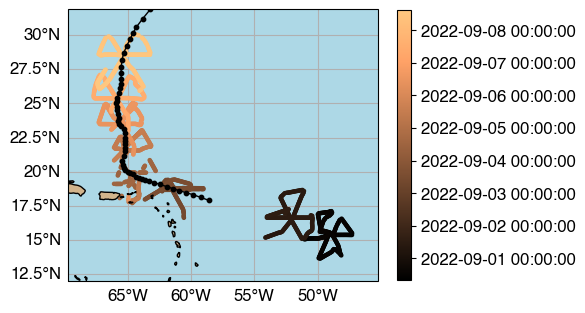

In [15]:
ax = earl_ds.wsra.plot(
    column='timestamp',
    cmap='copper',
    legend=True,
    legend_kwds={
     'shrink': 0.7,
    }
)
cax = ax.get_figure().axes[-1]
date_ticks = pd.date_range(start=earl_ds['time'][0].dt.ceil('D').values,
                           end=earl_ds['time'][-1].dt.floor('D').values,
                           freq='D')
_ = cax.set_yticks(pd.to_numeric(date_ticks), labels=date_ticks)

plt.savefig('wsra_hurricane_earl_time_tracks.png', dpi=IMAGE_RESOLUTION)

Subset the data

In [16]:
start_time = datetime(2022, 9, 4)
end_time = datetime(2022, 9, 9)
earl_ds_subset = earl_ds.sel(time=slice(start_time, end_time))

<GeoAxes: >

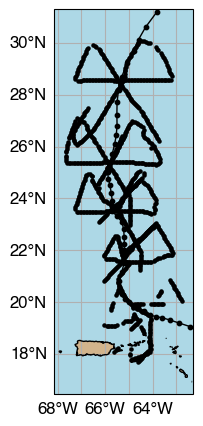

In [17]:
earl_ds_subset.wsra.plot()

In [18]:
earl_ds_subset['sea_surface_mean_square_slope_mean'] = earl_ds_subset['sea_surface_mean_square_slope'].mean(axis=1)
earl_ds_subset['sea_surface_mean_square_slope_std'] = earl_ds_subset['sea_surface_mean_square_slope'].std(axis=1)
earl_ds_subset['sea_surface_mean_square_slope_coeff_var'] = earl_ds_subset['sea_surface_mean_square_slope_std'] / earl_ds_subset['sea_surface_mean_square_slope_mean']
good_data = earl_ds_subset['sea_surface_mean_square_slope_coeff_var'] < 1
earl_ds_subset['sea_surface_mean_square_slope_mean_screened'] = earl_ds_subset['sea_surface_mean_square_slope_mean'].where(good_data)
earl_ds_subset['sea_surface_mean_square_slope_mean_screened'] = earl_ds_subset['sea_surface_mean_square_slope_mean'].where(good_data)

# fig, ax = plt.subplots()
# ax.plot(earl_ds_subset['time'], earl_ds_subset['sea_surface_mean_square_slope_coeff_var'])

### Slant path attenuation correction


\begin{equation*}

\textrm{mss} = \frac{1}{\frac{1}{\textrm{mss}_0} - \frac{\mathrm{DN}}{20\log_{10}{(e)}}}

\end{equation*}

where $\mathrm{DN}$ is the attenuation in dB calculated as:

\begin{equation*}

\mathrm{DN} = 0.16 R h \sqrt{1 + x}

\end{equation*}

with $x=\tan{\theta}^2$


In [84]:
# DN = alpha * R * h
def rain_attenuation(rain_rate, altitude_km):
    alpha = 0.16 # 2-way attenuation coeff in dBZ/km/(mm/hr)
    return  alpha * rain_rate * altitude_km

def rain_correct_mss(mss_0, rain_rate, altitude):
    altitude_km = altitude * 10**(-3)
    atten = rain_attenuation(rain_rate, altitude_km)
    const = 20 * np.log10(np.e)
    return (1/mss_0 - atten/const)**(-1)

#mss0 = 0.060
# R = 19.1  # mm/hr
# h = 3  # km
# rain_correct_mss(mss0, R, h)

In [100]:
earl_ds_subset['sea_surface_mean_square_slope_mean_corrected'] = rain_correct_mss(
    mss_0=earl_ds_subset['sea_surface_mean_square_slope_mean_screened'],
    rain_rate=earl_ds_subset['rainfall_rate_median'],
    altitude=earl_ds_subset['platform_radar_altitude'],
)

(0.0, 40.0)

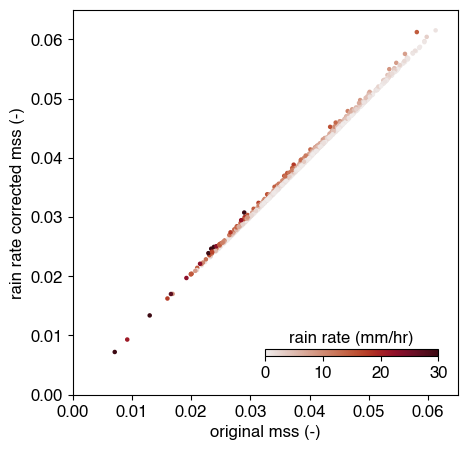

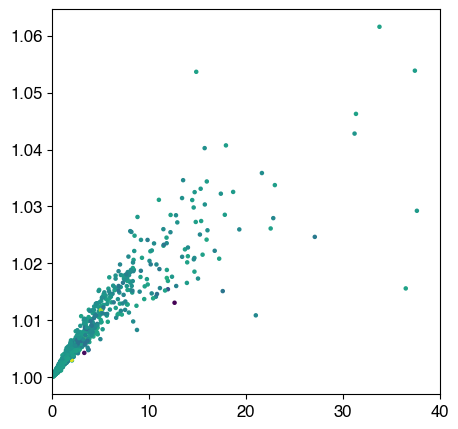

In [214]:
norm = mpl.colors.Normalize(vmin=0, vmax=30)
cmap = cmocean.cm.amp
fig, ax = plt.subplots(figsize=(5, 5))
comparison_plot = ax.scatter(earl_ds_subset['sea_surface_mean_square_slope_mean_screened'],
          earl_ds_subset['sea_surface_mean_square_slope_mean_corrected'],
          c=earl_ds_subset['rainfall_rate_median'],
          s=5,
          norm=norm,
          cmap=cmap)
ax.set_aspect('equal')
ax.set_ylabel('rain rate corrected mss (-)')
ax.set_xlabel('original mss (-)')
ax.set_xlim([0, 0.065])
ax.set_ylim([0, 0.065])

cax = ax.inset_axes([0.5, 0.10, 0.45, 0.02], axes_class=mpl.axes.Axes)  # [x0, y0, width, height]
cbar = plt.colorbar(comparison_plot, cax=cax, orientation='horizontal')
cax.xaxis.set_label_position('top')
cbar.set_label('rain rate (mm/hr)')
fig.savefig('wsra_earl_mss_corrected_for_rainfall.png', dpi=400)


# ratio = earl_ds_subset['sea_surface_mean_square_slope_mean_corrected']/earl_ds_subset['sea_surface_mean_square_slope_mean_screened']
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(
#     earl_ds_subset['rainfall_rate_median'],
#     ratio,
#     c=earl_ds_subset['platform_radar_altitude'],
#     s=5,
# )
# ax.set_xlim([0, 40])

### Transects

In [144]:
trsct_1_start = datetime(2022, 9, 5, 10, 43)
trsct_1_end = datetime(2022, 9, 5, 11, 10)
earl_ds_trsct_1 = earl_ds_subset.sel(time=slice(trsct_1_start, trsct_1_end))

trsct_2_start = datetime(2022, 9, 6, 10, 59)
trsct_2_end = datetime(2022, 9, 6, 11, 42)
earl_ds_trsct_2 = earl_ds_subset.sel(time=slice(trsct_2_start, trsct_2_end))

trsct_3_start = datetime(2022, 9, 7, 10, 55)
trsct_3_end = datetime(2022, 9, 7, 11, 45)
earl_ds_trsct_3 = earl_ds_subset.sel(time=slice(trsct_3_start, trsct_3_end))

trsct_4_start = datetime(2022, 9, 8, 11, 25)
trsct_4_end = datetime(2022, 9, 8, 12, 20)
earl_ds_trsct_4 = earl_ds_subset.sel(time=slice(trsct_4_start, trsct_4_end))



In [20]:
def print_trsct(start_time, end_time):
    print(f'start: {pd.Timestamp(start_time).isoformat()}\n'
          f'end:   {pd.Timestamp(end_time).isoformat()}')

In [145]:
print('transect 1')
print_trsct(trsct_1_start, trsct_1_end)
print('transect 2')
print_trsct(trsct_2_start, trsct_2_end)
print('transect 3')
print_trsct(trsct_3_start, trsct_3_end)
print('transect 4')
print_trsct(trsct_4_start, trsct_4_end)

transect 1
start: 2022-09-05T10:43:00
end:   2022-09-05T11:10:00
transect 2
start: 2022-09-06T10:59:00
end:   2022-09-06T11:42:00
transect 3
start: 2022-09-07T10:55:00
end:   2022-09-07T11:45:00
transect 4
start: 2022-09-08T11:25:00
end:   2022-09-08T12:20:00


/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_21237/2593938061.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  INTENSITY_CMAP = cmap = mpl.cm.get_cmap('YlOrRd', 7)  # discrete colors


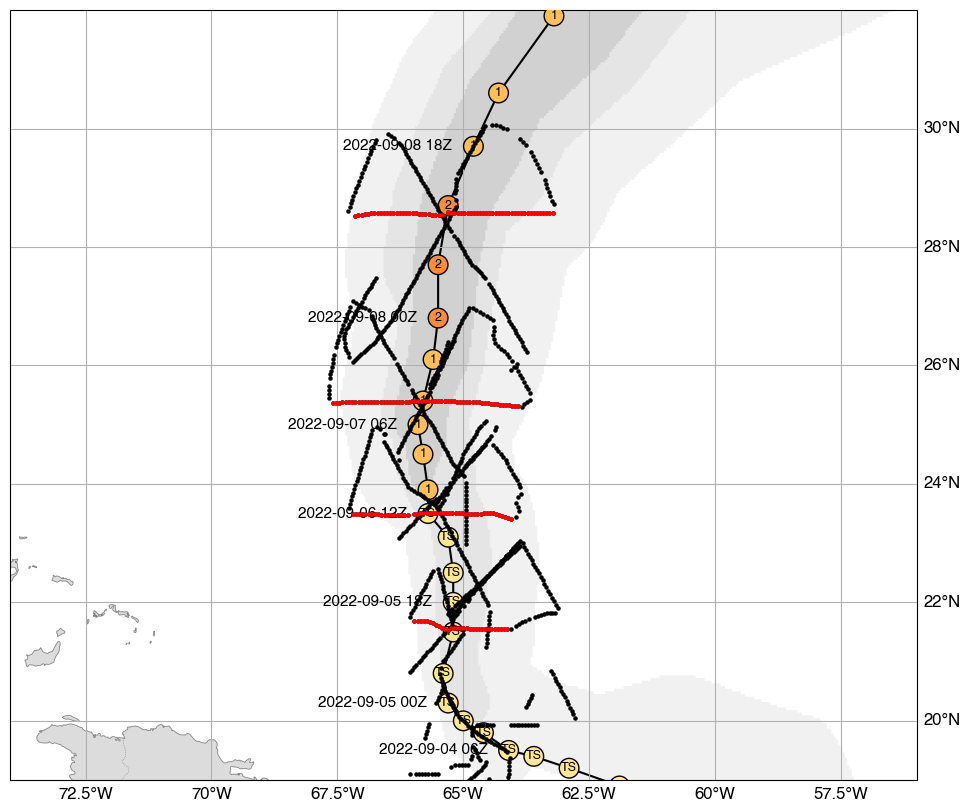

In [22]:
FIG_TITLE = f"wsra_hurricane_earl_transects"
FIG_SIZE = (12, 10)
EXTENT = np.array([-74, -56, 19, 32])
COLOR_MAP = 'Spectral_r' #'RdYlBu_r'
INTENSITY_CMAP = cmap = mpl.cm.get_cmap('YlOrRd', 7)  # discrete colors
CRS = cartopy.crs.PlateCarree()
OCEAN_COLOR = 'white'  #'lightblue' 'steelblue'
LAND_COLOR = 'gainsboro'  #'papayawhip'
COAST_BORDER_KWARGS = dict(
    edgecolor='grey',
    linewidth=0.5
)

# Initialize the figure, crop it based on extent, and add gridlines
fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
transform = CRS._as_mpl_transform(ax)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False) # zorder=0)
gridlines.top_labels = False
gridlines.left_labels = False
gridlines.right_labels = True

# Add the ocean, land, coastline, and border features
ax.add_feature(cartopy.feature.OCEAN, color=OCEAN_COLOR)
ax.add_feature(cartopy.feature.LAND, color=LAND_COLOR)
ax.add_feature(cartopy.feature.COASTLINE, **COAST_BORDER_KWARGS)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', **COAST_BORDER_KWARGS)
states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none', **COAST_BORDER_KWARGS)
ax.add_feature(states_provinces, edgecolor='black', zorder=5)

earl_lin.plot(
    color='k',
    zorder=2,
    ax=ax
)

earl_windswath[earl_windswath['RADII'] == 64.0].plot(
    facecolor='dimgrey',
    alpha=0.3,
    ax=ax,
)

earl_windswath[earl_windswath['RADII'] == 50.0].plot(
    facecolor='darkgrey',
    alpha=0.3,
    ax=ax,
)

earl_windswath[earl_windswath['RADII'] == 34.0].plot(
    facecolor='lightgrey',
    alpha=0.3,
    ax=ax,
)

# Plot the best track points; color and label by intensity
earl_pts.plot(
    column = 'SS_int',
    cmap = INTENSITY_CMAP,
    vmin = -1.5,
    vmax = 5.5,
    edgecolor = 'k',
    zorder=4,
    markersize = 200,
    alpha = 1.0,
    ax=ax,
)

for x, y, label in zip(earl_pts.geometry.x, earl_pts.geometry.y, earl_pts['SS_label']):
    ax.annotate(label, xy=(x, y), annotation_clip=True, ha='center', va='center', zorder=10, fontsize=9,
    xycoords=CRS._as_mpl_transform(ax), #TODO: needed?
        bbox=dict(boxstyle='circle,pad=0', fc='none', ec='none'))

counter = 0
for x, y, label in zip(earl_pts.geometry.x, earl_pts.geometry.y, earl_pts.index):
    if counter % 3 == 0:
        ax.annotate(label.strftime('%Y-%m-%d %HZ') + '     ', xy=(x, y), annotation_clip=True, ha='right', va='center', zorder=10, fontsize=11,
            bbox=dict(boxstyle='circle,pad=0', fc='none', ec='none'))
    counter += 1

# Plot the WSRA position
position_plot = ax.scatter(
    earl_ds_subset['longitude'],
    earl_ds_subset['latitude'],
    color='k',
    s=5,
    zorder=10,
)

position_plot = ax.scatter(
    earl_ds_trsct_1['longitude'],
    earl_ds_trsct_1['latitude'],
    color='r',
    s=5,
    zorder=12,
)

position_plot = ax.scatter(
    earl_ds_trsct_2['longitude'],
    earl_ds_trsct_2['latitude'],
    color='r',
    s=5,
    zorder=12,
)


position_plot = ax.scatter(
    earl_ds_trsct_3['longitude'],
    earl_ds_trsct_3['latitude'],
    color='r',
    s=5,
    zorder=12,
)

position_plot = ax.scatter(
    earl_ds_trsct_4['longitude'],
    earl_ds_trsct_4['latitude'],
    color='r',
    s=5,
    zorder=12,
)

# fig.savefig(FIG_TITLE + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)
plt.show()



In [23]:
date_range = pd.date_range(start=datetime(2022,9,4),
                           end=datetime(2022,9,9),
                           freq='5D')
date_range = pd.to_numeric(date_range)
time_vmin = pd.to_numeric(date_range[0])
time_vmax = pd.to_numeric(date_range[-1])
# NORM = mpl.colors.Normalize(vmin=time_vmin, vmax=time_vmax)

/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_21237/3819066724.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  INTENSITY_CMAP = cmap = mpl.cm.get_cmap('YlOrRd', 7)  # discrete colors


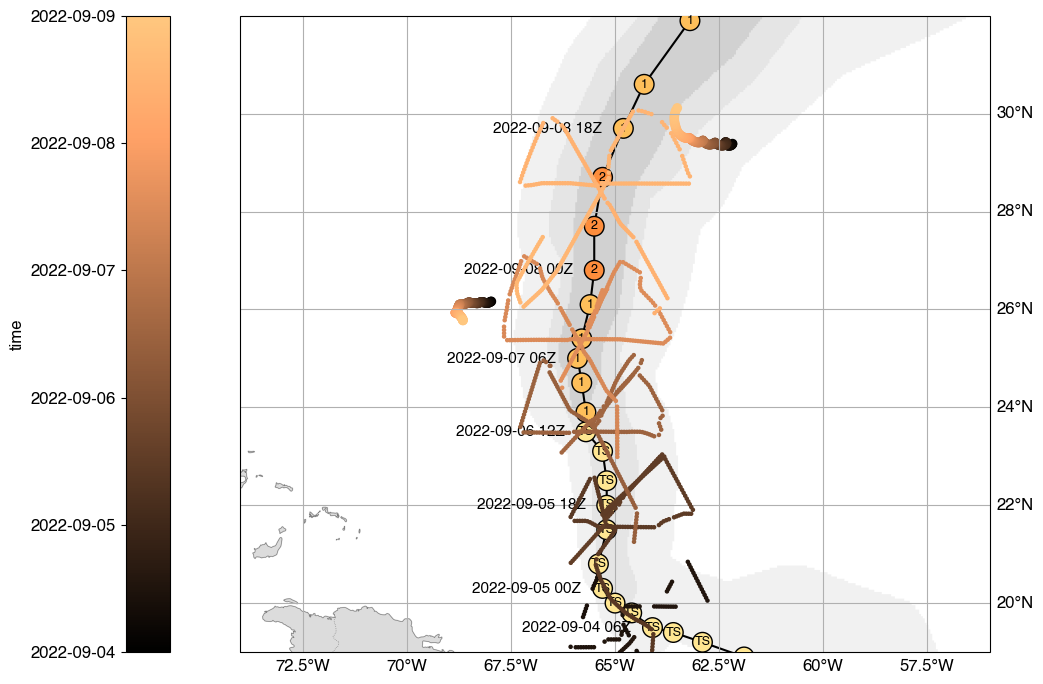

In [24]:
FIG_TITLE = f"wsra_hurricane_earl_track_with_spotters"
FIG_SIZE = (12, 10)
EXTENT = np.array([-74, -56, 19, 32])
COLOR_MAP = 'copper' #'RdYlBu_r'
INTENSITY_CMAP = cmap = mpl.cm.get_cmap('YlOrRd', 7)  # discrete colors
CRS = cartopy.crs.PlateCarree()
OCEAN_COLOR = 'white'  #'lightblue' 'steelblue'
LAND_COLOR = 'gainsboro'  #'papayawhip'
COAST_BORDER_KWARGS = dict(
    edgecolor='grey',
    linewidth=0.5
)

date_range = pd.date_range(start=datetime(2022,9,4),
                           end=datetime(2022,9,9),
                           freq='D')
date_range_numeric = pd.to_numeric(date_range)
time_vmin = pd.to_numeric(date_range_numeric[0])
time_vmax = pd.to_numeric(date_range_numeric[-1])
NORM = mpl.colors.Normalize(vmin=time_vmin, vmax=time_vmax)

# Initialize the figure, crop it based on extent, and add gridlines
fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
transform = CRS._as_mpl_transform(ax)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False) # zorder=0)
gridlines.top_labels = False
gridlines.left_labels = False
gridlines.right_labels = True

# Add the ocean, land, coastline, and border features
ax.add_feature(cartopy.feature.OCEAN, color=OCEAN_COLOR)
ax.add_feature(cartopy.feature.LAND, color=LAND_COLOR)
ax.add_feature(cartopy.feature.COASTLINE, **COAST_BORDER_KWARGS)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', **COAST_BORDER_KWARGS)
states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none', **COAST_BORDER_KWARGS)
ax.add_feature(states_provinces, edgecolor='black', zorder=5)

earl_lin.plot(
    color='k',
    zorder=2,
    ax=ax
)

earl_windswath[earl_windswath['RADII'] == 64.0].plot(
    facecolor='dimgrey',
    alpha=0.3,
    ax=ax,
)

earl_windswath[earl_windswath['RADII'] == 50.0].plot(
    facecolor='darkgrey',
    alpha=0.3,
    ax=ax,
)

earl_windswath[earl_windswath['RADII'] == 34.0].plot(
    facecolor='lightgrey',
    alpha=0.3,
    ax=ax,
)

# Plot the best track points; color and label by intensity
earl_pts.plot(
    column = 'SS_int',
    cmap = INTENSITY_CMAP,
    vmin = -1.5,
    vmax = 5.5,
    edgecolor = 'k',
    zorder=4,
    markersize = 200,
    alpha = 1.0,
    ax=ax,
)

for x, y, label in zip(earl_pts.geometry.x, earl_pts.geometry.y, earl_pts['SS_label']):
    ax.annotate(label, xy=(x, y), annotation_clip=True, ha='center', va='center', zorder=10, fontsize=9,
    xycoords=CRS._as_mpl_transform(ax), #TODO: needed?
        bbox=dict(boxstyle='circle,pad=0', fc='none', ec='none'))

counter = 0
for x, y, label in zip(earl_pts.geometry.x, earl_pts.geometry.y, earl_pts.index):
    if counter % 3 == 0:
        ax.annotate(label.strftime('%Y-%m-%d %HZ') + '     ', xy=(x, y), annotation_clip=True, ha='right', va='center', zorder=10, fontsize=11,
            bbox=dict(boxstyle='circle,pad=0', fc='none', ec='none'))
    counter += 1


# Plot the WSRA position
position_plot = ax.scatter(
    earl_ds_subset['longitude'],
    earl_ds_subset['latitude'],
    c=earl_ds_subset['timestamp'],
    cmap=COLOR_MAP,
    norm=NORM,
    s=5,
    zorder=10,
)

# Plot the Spotter position

spotter_plot = ax.scatter(
    spotters['longitude'],
    spotters['latitude'],
    cmap=COLOR_MAP,
    norm=NORM,
    c=pd.to_numeric(pd.to_datetime(spotters['time']))
)


# ax.annotate(label
#         , # spaces to offset
#         xy=coords[0].coords[0],
#         xycoords=transform,
#         zorder=10,
#         annotation_clip=True,
#         **annotate_kwargs
#     )


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('left', size='5%', pad=0.05, axes_class=mpl.axes.Axes)
fig.colorbar(mpl.cm.ScalarMappable(norm=NORM, cmap=COLOR_MAP),
             cax=cax, orientation='vertical', location='left',
             label='time')

cax.set_yticks(date_range_numeric,
               labels=date_range.strftime('%Y-%m-%d'))


# fig.savefig(FIG_TITLE + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)
plt.show()



/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_21237/2001022458.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  INTENSITY_CMAP = cmap = mpl.cm.get_cmap('YlOrRd', 7)  # discrete colors


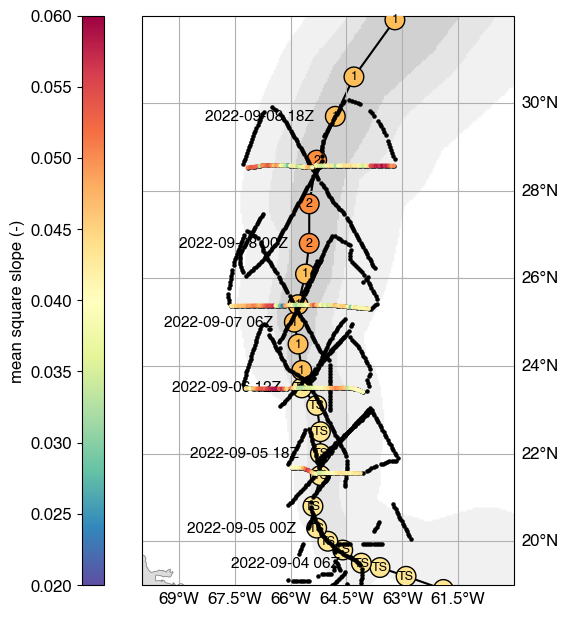

In [25]:
FIG_TITLE = f"wsra_hurricane_earl_mss_transects"
FIG_SIZE = (6, 10)
EXTENT = np.array([-70, -60, 19, 32])
COLOR_MAP = 'Spectral_r' #'RdYlBu_r'
INTENSITY_CMAP = cmap = mpl.cm.get_cmap('YlOrRd', 7)  # discrete colors
CRS = cartopy.crs.PlateCarree()
OCEAN_COLOR = 'white'  #'lightblue' 'steelblue'
LAND_COLOR = 'gainsboro'  #'papayawhip'
COAST_BORDER_KWARGS = dict(
    edgecolor='grey',
    linewidth=0.5
)

# Initialize the figure, crop it based on extent, and add gridlines
fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
transform = CRS._as_mpl_transform(ax)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False) # zorder=0)
gridlines.top_labels = False
gridlines.left_labels = False
gridlines.right_labels = True

# Add the ocean, land, coastline, and border features
ax.add_feature(cartopy.feature.OCEAN, color=OCEAN_COLOR)
ax.add_feature(cartopy.feature.LAND, color=LAND_COLOR)
ax.add_feature(cartopy.feature.COASTLINE, **COAST_BORDER_KWARGS)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', **COAST_BORDER_KWARGS)
states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none', **COAST_BORDER_KWARGS)
ax.add_feature(states_provinces, edgecolor='black', zorder=5)

earl_lin.plot(
    color='k',
    zorder=2,
    ax=ax
)

earl_windswath[earl_windswath['RADII'] == 64.0].plot(
    facecolor='dimgrey',
    alpha=0.3,
    ax=ax,
)

earl_windswath[earl_windswath['RADII'] == 50.0].plot(
    facecolor='darkgrey',
    alpha=0.3,
    ax=ax,
)

earl_windswath[earl_windswath['RADII'] == 34.0].plot(
    facecolor='lightgrey',
    alpha=0.3,
    ax=ax,
)

# Plot the best track points; color and label by intensity
earl_pts.plot(
    column = 'SS_int',
    cmap = INTENSITY_CMAP,
    vmin = -1.5,
    vmax = 5.5,
    edgecolor = 'k',
    zorder=4,
    markersize = 200,
    alpha = 1.0,
    ax=ax,
)

for x, y, label in zip(earl_pts.geometry.x, earl_pts.geometry.y, earl_pts['SS_label']):
    ax.annotate(label, xy=(x, y), annotation_clip=True, ha='center', va='center', zorder=10, fontsize=9,
    xycoords=CRS._as_mpl_transform(ax), #TODO: needed?
        bbox=dict(boxstyle='circle,pad=0', fc='none', ec='none'))

counter = 0
for x, y, label in zip(earl_pts.geometry.x, earl_pts.geometry.y, earl_pts.index):
    if counter % 3 == 0:
        ax.annotate(label.strftime('%Y-%m-%d %HZ') + '     ', xy=(x, y), annotation_clip=True, ha='right', va='center', zorder=10, fontsize=11,
            bbox=dict(boxstyle='circle,pad=0', fc='none', ec='none'))
    counter += 1

# Plot the WSRA position
position_plot = ax.scatter(
    earl_ds_subset['longitude'],
    earl_ds_subset['latitude'],
    color='k',
    s=5,
    zorder=10,
)


mss_vmin = 0.02
mss_vmax = 0.06
norm = mpl.colors.Normalize(vmin=mss_vmin, vmax=mss_vmax)


position_plot = ax.scatter(
    earl_ds_trsct_1['longitude'],
    earl_ds_trsct_1['latitude'],
    c=earl_ds_trsct_1['sea_surface_mean_square_slope_mean_screened'],
    s=5,
    zorder=12,
    cmap=COLOR_MAP,
    norm=norm,
)

position_plot = ax.scatter(
    earl_ds_trsct_2['longitude'],
    earl_ds_trsct_2['latitude'],
    c=earl_ds_trsct_2['sea_surface_mean_square_slope_mean_screened'],
    s=5,
    zorder=12,
    cmap=COLOR_MAP,
    norm=norm,
)


position_plot = ax.scatter(
    earl_ds_trsct_3['longitude'],
    earl_ds_trsct_3['latitude'],
    c=earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'],
    s=5,
    zorder=12,
    cmap=COLOR_MAP,
    norm=norm,
)


position_plot = ax.scatter(
    earl_ds_trsct_4['longitude'],
    earl_ds_trsct_4['latitude'],
    c=earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened'],
    s=5,
    zorder=12,
    cmap=COLOR_MAP,
    norm=norm,
)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('left', size='5%', pad=0.05, axes_class=mpl.axes.Axes)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=COLOR_MAP),
             cax=cax, orientation='vertical', location='left', label='mean square slope (-)')

# fig.savefig(FIG_TITLE + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)
plt.show()



/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_21237/506618300.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  INTENSITY_CMAP = cmap = mpl.cm.get_cmap('YlOrRd', 7)  # discrete colors


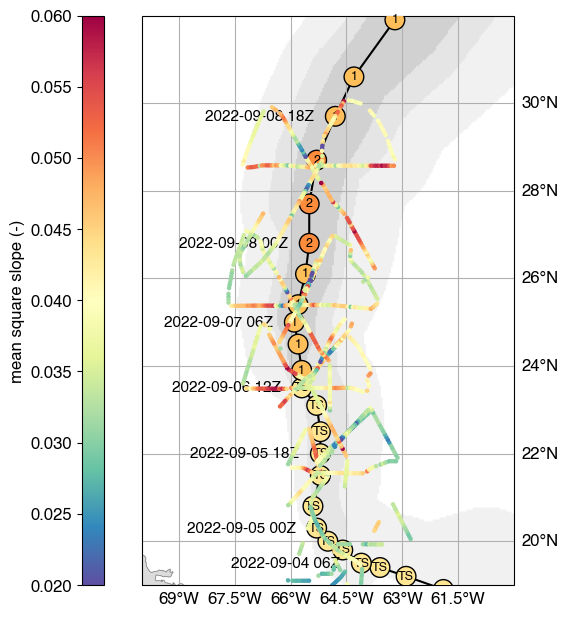

In [26]:
FIG_TITLE = f"wsra_hurricane_earl_mss_transects"
FIG_SIZE = (6, 10)
EXTENT = np.array([-70, -60, 19, 32])
COLOR_MAP = 'Spectral_r' #'RdYlBu_r'
INTENSITY_CMAP = cmap = mpl.cm.get_cmap('YlOrRd', 7)  # discrete colors
CRS = cartopy.crs.PlateCarree()
OCEAN_COLOR = 'white'  #'lightblue' 'steelblue'
LAND_COLOR = 'gainsboro'  #'papayawhip'
COAST_BORDER_KWARGS = dict(
    edgecolor='grey',
    linewidth=0.5
)

# Initialize the figure, crop it based on extent, and add gridlines
fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
transform = CRS._as_mpl_transform(ax)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False) # zorder=0)
gridlines.top_labels = False
gridlines.left_labels = False
gridlines.right_labels = True

# Add the ocean, land, coastline, and border features
ax.add_feature(cartopy.feature.OCEAN, color=OCEAN_COLOR)
ax.add_feature(cartopy.feature.LAND, color=LAND_COLOR)
ax.add_feature(cartopy.feature.COASTLINE, **COAST_BORDER_KWARGS)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', **COAST_BORDER_KWARGS)
states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none', **COAST_BORDER_KWARGS)
ax.add_feature(states_provinces, edgecolor='black', zorder=5)

earl_lin.plot(
    color='k',
    zorder=2,
    ax=ax
)

earl_windswath[earl_windswath['RADII'] == 64.0].plot(
    facecolor='dimgrey',
    alpha=0.3,
    ax=ax,
)

earl_windswath[earl_windswath['RADII'] == 50.0].plot(
    facecolor='darkgrey',
    alpha=0.3,
    ax=ax,
)

earl_windswath[earl_windswath['RADII'] == 34.0].plot(
    facecolor='lightgrey',
    alpha=0.3,
    ax=ax,
)

# Plot the best track points; color and label by intensity
earl_pts.plot(
    column = 'SS_int',
    cmap = INTENSITY_CMAP,
    vmin = -1.5,
    vmax = 5.5,
    edgecolor = 'k',
    zorder=4,
    markersize = 200,
    alpha = 1.0,
    ax=ax,
)

for x, y, label in zip(earl_pts.geometry.x, earl_pts.geometry.y, earl_pts['SS_label']):
    ax.annotate(label, xy=(x, y), annotation_clip=True, ha='center', va='center', zorder=10, fontsize=9,
    xycoords=CRS._as_mpl_transform(ax), #TODO: needed?
        bbox=dict(boxstyle='circle,pad=0', fc='none', ec='none'))

counter = 0
for x, y, label in zip(earl_pts.geometry.x, earl_pts.geometry.y, earl_pts.index):
    if counter % 3 == 0:
        ax.annotate(label.strftime('%Y-%m-%d %HZ') + '     ', xy=(x, y), annotation_clip=True, ha='right', va='center', zorder=10, fontsize=11,
            bbox=dict(boxstyle='circle,pad=0', fc='none', ec='none'))
    counter += 1

# Plot the WSRA position
position_plot = ax.scatter(
    earl_ds_subset['longitude'],
    earl_ds_subset['latitude'],
    c=earl_ds_subset['sea_surface_mean_square_slope_mean'],
    cmap=COLOR_MAP,
    norm=norm,
    s=5,
    zorder=10,
)


mss_vmin = 0.02
mss_vmax = 0.06
norm = mpl.colors.Normalize(vmin=mss_vmin, vmax=mss_vmax)


# position_plot = ax.scatter(
#     earl_ds_trsct_1['longitude'],
#     earl_ds_trsct_1['latitude'],
#     c=earl_ds_trsct_1['sea_surface_mean_square_slope_mean_screened'],
#     s=5,
#     zorder=12,
#     cmap=COLOR_MAP,
#     norm=norm,
# )

# position_plot = ax.scatter(
#     earl_ds_trsct_2['longitude'],
#     earl_ds_trsct_2['latitude'],
#     c=earl_ds_trsct_2['sea_surface_mean_square_slope_mean_screened'],
#     s=5,
#     zorder=12,
#     cmap=COLOR_MAP,
#     norm=norm,
# )


# position_plot = ax.scatter(
#     earl_ds_trsct_3['longitude'],
#     earl_ds_trsct_3['latitude'],
#     c=earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'],
#     s=5,
#     zorder=12,
#     cmap=COLOR_MAP,
#     norm=norm,
# )


# position_plot = ax.scatter(
#     earl_ds_trsct_4['longitude'],
#     earl_ds_trsct_4['latitude'],
#     c=earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened'],
#     s=5,
#     zorder=12,
#     cmap=COLOR_MAP,
#     norm=norm,
# )

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('left', size='5%', pad=0.05, axes_class=mpl.axes.Axes)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=COLOR_MAP),
             cax=cax, orientation='vertical', location='left', label='mean square slope (-)')

# fig.savefig(FIG_TITLE + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)
plt.show()



Text(0.5, 0, 'east distance from hurricane eye (km)')

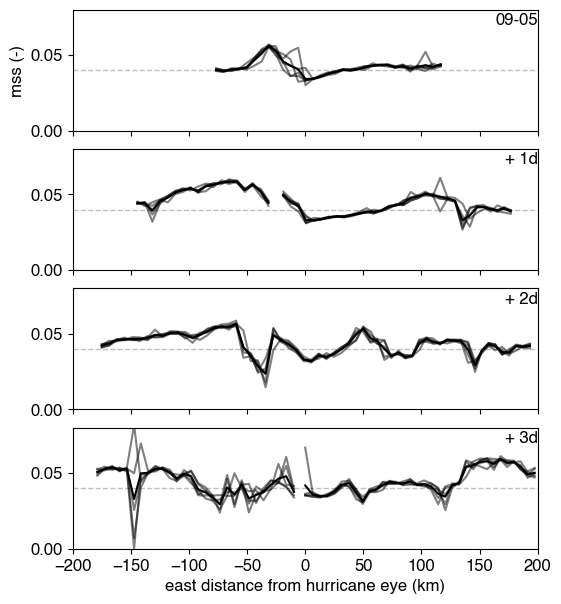

In [27]:
FIG_TITLE = 'wsra_earl_mss_transect_stacks'

fig, ax = plt.subplots(4, 1, figsize=(6, 7), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.15)

ax[0].plot(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['sea_surface_mean_square_slope'], color='k', alpha=0.5)
ax[0].plot(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['sea_surface_mean_square_slope_mean_screened'], color='k')
ax[0].annotate('09-05', (200, 0.07), ha='right')
ax[0].axhline(0.04, color='k', linestyle='--', linewidth=1, alpha=0.25)

ax[1].plot(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['sea_surface_mean_square_slope'], color='k', alpha=0.5)
ax[1].plot(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['sea_surface_mean_square_slope_mean_screened'], color='k')
ax[1].annotate('+ 1d', (200, 0.07), ha='right')
ax[1].axhline(0.04, color='k', linestyle='--', linewidth=1, alpha=0.25)

ax[2].plot(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['sea_surface_mean_square_slope'], color='k', alpha=0.5)
ax[2].plot(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'], color='k')
ax[2].annotate('+ 2d', (200, 0.07), ha='right')
ax[2].axhline(0.04, color='k', linestyle='--', linewidth=1, alpha=0.25)

# ['hurricane_eye_distance_east']*1.25
ax[3].plot(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['sea_surface_mean_square_slope'], color='k', alpha=0.5)
ax[3].plot(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened'], color='k')
ax[3].annotate('+ 3d', (200, 0.07), ha='right')
ax[3].axhline(0.04, color='k', linestyle='--', linewidth=1, alpha=0.25)

ax[0].set_ylim([0.0, 0.08])
ax[0].set_xlim(2*10**2 * np.array([-1, 1]))
ax[0].set_ylabel('mss (-)')
ax[-1].set_xlabel('east distance from hurricane eye (km)')

# fig.savefig(FIG_TITLE + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)


Text(0.5, 0, 'east distance from hurricane eye (km)')

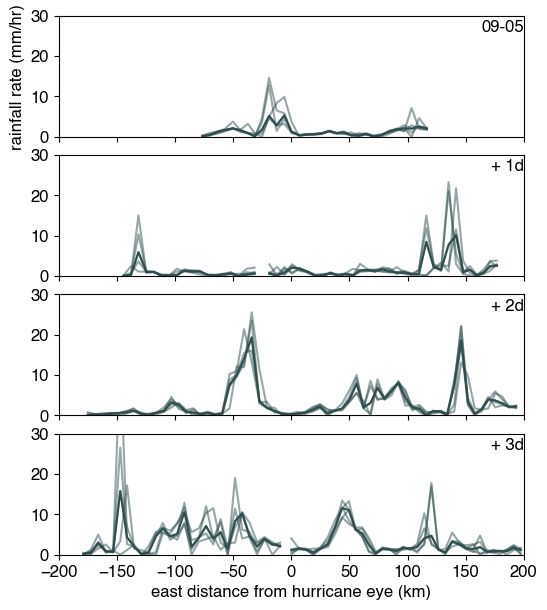

In [28]:
FIG_TITLE = 'wsra_earl_rainfall_rate_transect_stacks'

fig, ax = plt.subplots(4, 1, figsize=(6, 7), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.15)

ax[0].plot(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['rainfall_rate'], color='darkslategray', alpha=0.5)
ax[0].plot(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['rainfall_rate_median'], color='darkslategray')
ax[0].annotate('09-05', (200, 26), ha='right')

ax[1].plot(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['rainfall_rate'], color='darkslategray', alpha=0.5)
ax[1].plot(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['rainfall_rate_median'], color='darkslategray')
ax[1].annotate('+ 1d', (200, 26), ha='right')

ax[2].plot(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['rainfall_rate'], color='darkslategray', alpha=0.5)
ax[2].plot(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['rainfall_rate_median'], color='darkslategray')
ax[2].annotate('+ 2d', (200, 26), ha='right')

# ['hurricane_eye_distance_east']*1.25
ax[3].plot(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['rainfall_rate'], color='darkslategray', alpha=0.5)
ax[3].plot(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['rainfall_rate_median'], color='darkslategray')
ax[3].annotate('+ 3d', (200, 26), ha='right')

ax[0].set_ylim([0.0, 30])
ax[0].set_xlim(2*10**2 * np.array([-1, 1]))
ax[0].set_ylabel('rainfall rate (mm/hr)')
ax[-1].set_xlabel('east distance from hurricane eye (km)')

# fig.savefig(FIG_TITLE + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)


In [29]:
earl_ds_trsct_1

<xarray.Dataset>
Dimensions:                                      (time: 32,
                                                  wavenumber_east: 65,
                                                  wavenumber_north: 65, obs: 5,
                                                  wavelength: 8)
Coordinates:
  * time                                         (time) datetime64[ns] 2022-0...
  * wavenumber_east                              (wavenumber_east) float32 -0...
  * wavenumber_north                             (wavenumber_north) float32 -...
  * wavelength                                   (wavelength) float32 366.0 ....
  * obs                                          (obs) timedelta64[ns] -1 day...
    time_mask                                    (time) bool False True ... True
Data variables: (12/35)
    directional_wave_spectrum                    (time, wavenumber_east, wavenumber_north) float32 ...
    directional_wave_spectrum_180                (time, wavenumber_east, wavenumber_north) float32 ...
    dominant_to_secondary_partition_angle        (time) float32 nan nan ... nan
    dominant_wave_direction                      (time) float32 nan ... 38.32
    dominant_wave_height                         (time) float32 nan ... 1.986
    dominant_wave_wavelength                     (time) float32 nan ... 69.24
    ...                                           ...
    hurricane_eye_distance_north_storm_coord     (time) float64 nan ... 2.375...
    timestamp                                    (time) int64 166237460100000...
    sea_surface_mean_square_slope_mean           (time) float32 nan ... 0.04344
    sea_surface_mean_square_slope_std            (time) float32 nan ... 0.000...
    sea_surface_mean_square_slope_coeff_var      (time) float32 nan ... 0.01599
    sea_surface_mean_square_slope_mean_screened  (time) float32 nan ... 0.04344
Attributes:
    title:                ['WSRA level 4 data']
    history:              ['revision: 1.6; date: 20180816; author: NMS/IPS']
    flight_id:            ['20220831H1', '20220901H1', '20220903H1', '2022090...
    mission_id:           ['WEWXA TRAIN', 'WGWXA AL91', '0506A EARL', '0706A ...
    storm_id:             AL062022
    date_created:         ['2022-11-07T20:04:58Z', '2022-11-11T16:36:08Z', '2...
    time_coverage_start:  2022-08-31 08:10:53+00:00
    time_coverage_end:    2022-09-08 14:19:49+00:00

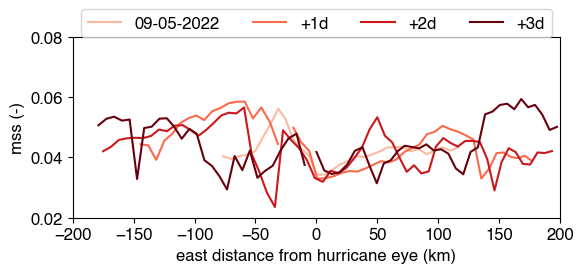

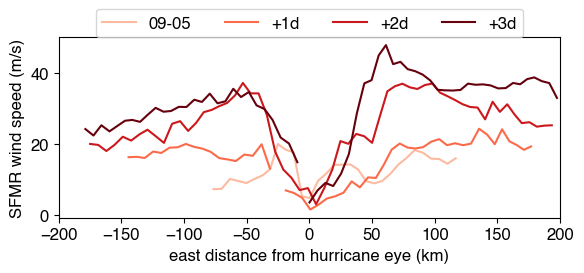

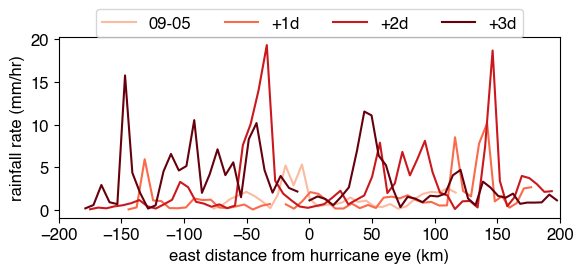

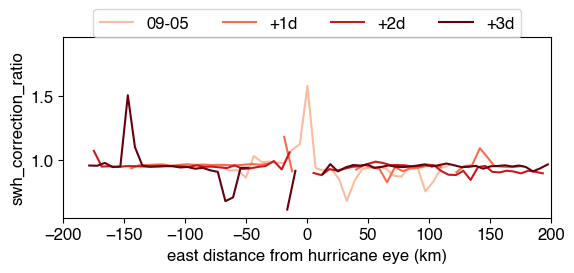

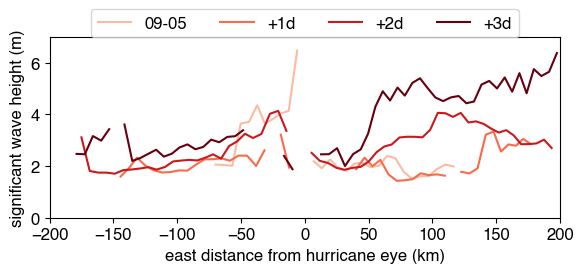

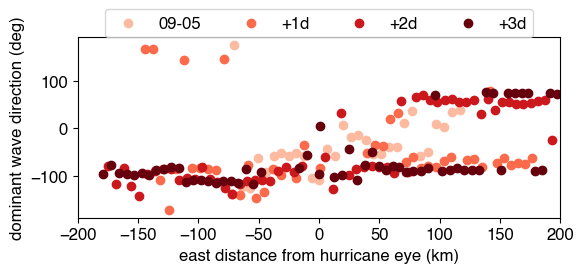

In [146]:
cmap = plt.get_cmap('Reds', 5)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['sea_surface_mean_square_slope_mean_screened'], color=cmap(1), label='09-05-2022')
ax.plot(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['sea_surface_mean_square_slope_mean_screened'], color=cmap(2), label='+1d')
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'], color=cmap(3), label='+2d')
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened'], color=cmap(4), label='+3d')
ax.set_ylim([0.02, 0.08])
ax.set_xlim(2*10**2 * np.array([-1, 1]))
ax.set_ylabel('mss (-)')
ax.set_xlabel('east distance from hurricane eye (km)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
fig.tight_layout()
# fig.savefig('wsra_earl_mss_transect_overlay' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['wind_speed'], color=cmap(1), label='09-05')
ax.plot(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['wind_speed'], color=cmap(2), label='+1d')
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['wind_speed'], color=cmap(3), label='+2d')
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['wind_speed'], color=cmap(4), label='+3d')
# ax.set_ylim([0.02, 0.08])
ax.set_xlim(2*10**2 * np.array([-1, 1]))
ax.set_ylabel('SFMR wind speed (m/s)')
ax.set_xlabel('east distance from hurricane eye (km)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
fig.tight_layout()
# fig.savefig('wsra_earl_wind_speed_transect_overlay' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['rainfall_rate_median'], color=cmap(1), label='09-05')
ax.plot(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['rainfall_rate_median'], color=cmap(2), label='+1d')
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['rainfall_rate_median'], color=cmap(3), label='+2d')
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['rainfall_rate_median'], color=cmap(4), label='+3d')
# ax.set_ylim([0.01, 0.075])
ax.set_xlim(2*10**2 * np.array([-1, 1]))
ax.set_ylabel('rainfall rate (mm/hr)')
ax.set_xlabel('east distance from hurricane eye (km)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
fig.tight_layout()
# fig.savefig('wsra_earl_rainfall_rate_transect_overlay' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['swh_correction_ratio'], color=cmap(1), label='09-05')
ax.plot(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['swh_correction_ratio'], color=cmap(2), label='+1d')
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['swh_correction_ratio'], color=cmap(3), label='+2d')
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['swh_correction_ratio'], color=cmap(4), label='+3d')
# ax.set_ylim([0.01, 0.075])
ax.set_xlim(2*10**2 * np.array([-1, 1]))
ax.set_ylabel('swh_correction_ratio')
ax.set_xlabel('east distance from hurricane eye (km)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
fig.tight_layout()
# fig.savefig('wsra_earl_swh_correction_ratio_transect_overlay' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
good_hs = earl_ds_trsct_1['swh_correction_ratio'] < 1.2
ax.plot(earl_ds_trsct_1['hurricane_eye_distance_east'].where(good_hs)/1000, earl_ds_trsct_1['sea_surface_wave_significant_height'].where(good_hs), color=cmap(1), label='09-05')
good_hs = earl_ds_trsct_2['swh_correction_ratio'] < 1.2
ax.plot(earl_ds_trsct_2['hurricane_eye_distance_east'].where(good_hs)/1000, earl_ds_trsct_2['sea_surface_wave_significant_height'].where(good_hs), color=cmap(2), label='+1d')
good_hs = earl_ds_trsct_3['swh_correction_ratio'] < 1.2
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east'].where(good_hs)/1000, earl_ds_trsct_3['sea_surface_wave_significant_height'].where(good_hs), color=cmap(3), label='+2d')
good_hs = earl_ds_trsct_4['swh_correction_ratio'] < 1.2
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east'].where(good_hs) /1000, earl_ds_trsct_4['sea_surface_wave_significant_height'].where(good_hs) , color=cmap(4), label='+3d')
ax.set_ylim([0, 7])
ax.set_xlim(2*10**2 * np.array([-1, 1]))
ax.set_ylabel('significant wave height (m)')
ax.set_xlabel('east distance from hurricane eye (km)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
fig.tight_layout()
# fig.savefig('wsra_earl_significant_height_transect_overlay' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(earl_ds_trsct_1['hurricane_eye_distance_east']/1000, earl_ds_trsct_1['dominant_wave_direction'], color=cmap(1), label='09-05')
ax.scatter(earl_ds_trsct_2['hurricane_eye_distance_east']/1000, earl_ds_trsct_2['dominant_wave_direction'], color=cmap(2), label='+1d')
ax.scatter(earl_ds_trsct_3['hurricane_eye_distance_east']/1000, earl_ds_trsct_3['dominant_wave_direction'], color=cmap(3), label='+2d')
ax.scatter(earl_ds_trsct_4['hurricane_eye_distance_east']/1000, earl_ds_trsct_4['dominant_wave_direction'], color=cmap(4), label='+3d')
# ax.set_ylim([0, 7])
ax.set_xlim(2*10**2 * np.array([-1, 1]))
ax.set_ylabel('dominant wave direction (deg)')
ax.set_xlabel('east distance from hurricane eye (km)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
fig.tight_layout()
# fig.savefig('wsra_earl_dom_wave_dir_transect_overlay' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)


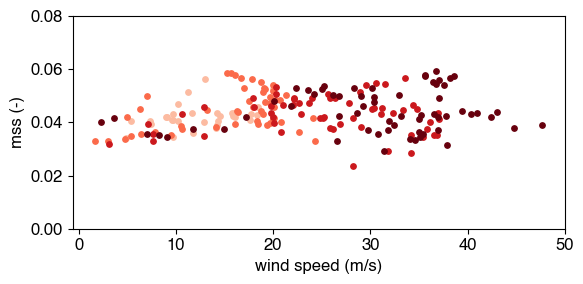

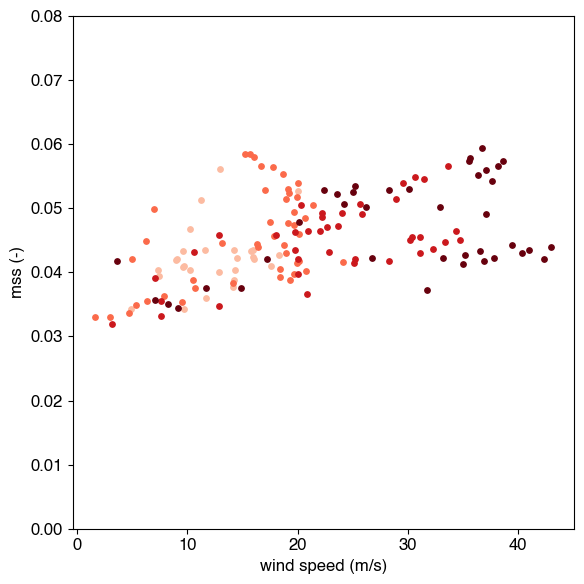

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(earl_ds_trsct_1['wind_speed'], earl_ds_trsct_1['sea_surface_mean_square_slope_mean_screened'], color=cmap(1), s=15)
ax.scatter(earl_ds_trsct_2['wind_speed'], earl_ds_trsct_2['sea_surface_mean_square_slope_mean_screened'], color=cmap(2), s=15)
ax.scatter(earl_ds_trsct_3['wind_speed'], earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'], color=cmap(3), s=15)
ax.scatter(earl_ds_trsct_4['wind_speed'], earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened'], color=cmap(4), s=15)
ax.set_ylim([0.00, 0.08])
ax.set_ylabel('mss (-)')
ax.set_xlabel('wind speed (m/s)')
fig.tight_layout()
# fig.savefig('wsra_earl_mss_versus_wind_speed' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
low_rainfall = earl_ds_trsct_1['rainfall_rate'].mean(axis=1) < 3
ax.scatter(earl_ds_trsct_1['wind_speed'][low_rainfall], earl_ds_trsct_1['sea_surface_mean_square_slope_mean_screened'][low_rainfall], color=cmap(1), s=15)
low_rainfall = earl_ds_trsct_2['rainfall_rate'].mean(axis=1) < 3
ax.scatter(earl_ds_trsct_2['wind_speed'][low_rainfall], earl_ds_trsct_2['sea_surface_mean_square_slope_mean_screened'][low_rainfall], color=cmap(2), s=15)
low_rainfall = earl_ds_trsct_3['rainfall_rate'].mean(axis=1) < 3
ax.scatter(earl_ds_trsct_3['wind_speed'][low_rainfall], earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'][low_rainfall], color=cmap(3), s=15)
low_rainfall = earl_ds_trsct_4['rainfall_rate'].mean(axis=1) < 3
ax.scatter(earl_ds_trsct_4['wind_speed'][low_rainfall], earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened'][low_rainfall], color=cmap(4), s=15)
ax.set_ylim([0.00, 0.08])
ax.set_ylabel('mss (-)')
ax.set_xlabel('wind speed (m/s)')
fig.tight_layout()
# fig.savefig('wsra_earl_mss_versus_wind_speed_rainfall_less_than_3mmph' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)


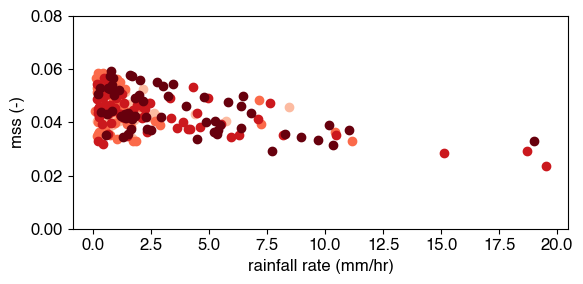

In [149]:
cmap = plt.get_cmap('Reds', 5)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(earl_ds_trsct_1['rainfall_rate'].mean(axis=1), earl_ds_trsct_1['sea_surface_mean_square_slope_mean_screened'], color=cmap(1))
ax.scatter(earl_ds_trsct_2['rainfall_rate'].mean(axis=1), earl_ds_trsct_2['sea_surface_mean_square_slope_mean_screened'], color=cmap(2))
ax.scatter(earl_ds_trsct_3['rainfall_rate'].mean(axis=1), earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'], color=cmap(3))
ax.scatter(earl_ds_trsct_4['rainfall_rate'].mean(axis=1), earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened'], color=cmap(4))
ax.set_ylim([0.0, 0.08])
ax.set_ylabel('mss (-)')
ax.set_xlabel('rainfall rate (mm/hr)')
fig.tight_layout()
# fig.savefig('wsra_earl_mss_versus_rainfall_rate' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)


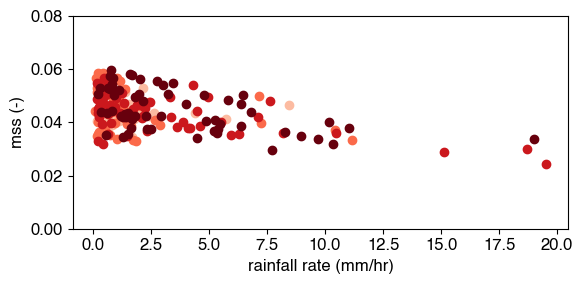

In [148]:
cmap = plt.get_cmap('Reds', 5)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(earl_ds_trsct_1['rainfall_rate'].mean(axis=1), earl_ds_trsct_1['sea_surface_mean_square_slope_mean_corrected'], color=cmap(1))
ax.scatter(earl_ds_trsct_2['rainfall_rate'].mean(axis=1), earl_ds_trsct_2['sea_surface_mean_square_slope_mean_corrected'], color=cmap(2))
ax.scatter(earl_ds_trsct_3['rainfall_rate'].mean(axis=1), earl_ds_trsct_3['sea_surface_mean_square_slope_mean_corrected'], color=cmap(3))
ax.scatter(earl_ds_trsct_4['rainfall_rate'].mean(axis=1), earl_ds_trsct_4['sea_surface_mean_square_slope_mean_corrected'], color=cmap(4))
ax.set_ylim([0.0, 0.08])
ax.set_ylabel('mss (-)')
ax.set_xlabel('rainfall rate (mm/hr)')
fig.tight_layout()
# fig.savefig('wsra_earl_mss_versus_rainfall_rate' + '.' + IMAGE_FILE_TYPE, dpi=IMAGE_RESOLUTION)

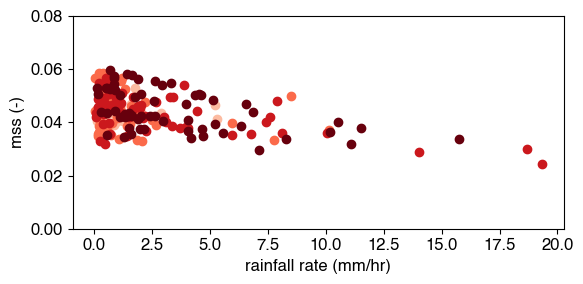

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(earl_ds_trsct_1['rainfall_rate_median'], earl_ds_trsct_1['sea_surface_mean_square_slope_mean_corrected'], color=cmap(1))
ax.scatter(earl_ds_trsct_2['rainfall_rate_median'], earl_ds_trsct_2['sea_surface_mean_square_slope_mean_corrected'], color=cmap(2))
ax.scatter(earl_ds_trsct_3['rainfall_rate_median'], earl_ds_trsct_3['sea_surface_mean_square_slope_mean_corrected'], color=cmap(3))
ax.scatter(earl_ds_trsct_4['rainfall_rate_median'], earl_ds_trsct_4['sea_surface_mean_square_slope_mean_corrected'], color=cmap(4))
ax.set_ylim([0.0, 0.08])
ax.set_ylabel('mss (-)')
ax.set_xlabel('rainfall rate (mm/hr)')
fig.tight_layout()

In [188]:
x = np.concatenate([earl_ds_trsct_1['rainfall_rate_median'],
                    earl_ds_trsct_2['rainfall_rate_median'],
                    earl_ds_trsct_3['rainfall_rate_median'],
                    earl_ds_trsct_4['rainfall_rate_median']])
y = np.concatenate([earl_ds_trsct_1['sea_surface_mean_square_slope_mean_screened'],
                    earl_ds_trsct_2['sea_surface_mean_square_slope_mean_screened'],
                    earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'],
                    earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened']])
y_corr = np.concatenate([earl_ds_trsct_1['sea_surface_mean_square_slope_mean_corrected'],
                    earl_ds_trsct_2['sea_surface_mean_square_slope_mean_corrected'],
                    earl_ds_trsct_3['sea_surface_mean_square_slope_mean_corrected'],
                    earl_ds_trsct_4['sea_surface_mean_square_slope_mean_corrected']])


y = y[~np.isnan(x)]
y_corr = y_corr[~np.isnan(x)]
x = x[~np.isnan(x)]

In [191]:
from scipy import stats
lin_fit = stats.linregress(x, y)
lin_fit_corr = stats.linregress(x, y_corr)

lin_fit_x = np.linspace(0, 20, 10)
lin_fit_y = lin_fit_x * lin_fit.slope + lin_fit.intercept
lin_fit_y_corr = lin_fit_x * lin_fit_corr.slope + lin_fit_corr.intercept


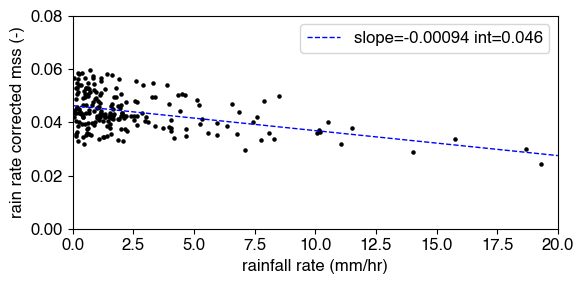

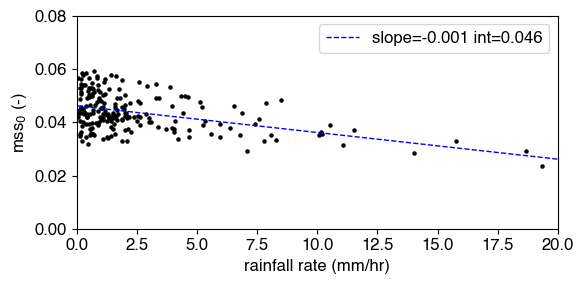

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(x, y_corr, s=5, color='k')
ax.plot(lin_fit_x, lin_fit_y_corr, color='b', linestyle='--', linewidth=1,
        label=f'slope={lin_fit_corr.slope.round(5)} '
              f'int={lin_fit_corr.intercept.round(3)}')
ax.set_ylim([0.0, 0.08])
ax.set_xlim([0.0, 20])
ax.set_ylabel('rain rate corrected mss (-)')
ax.set_xlabel('rainfall rate (mm/hr)')
ax.legend()
fig.tight_layout()
fig.savefig('wsra_earl_transect_mss_versus_rainfall_corrected.png', dpi=400)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(x, y, s=5, color='k')
ax.plot(lin_fit_x, lin_fit_y, color='b', linestyle='--', linewidth=1,
        label=f'slope={lin_fit.slope.round(5)} '
              f'int={lin_fit.intercept.round(3)}')
ax.set_ylim([0.0, 0.08])
ax.set_xlim([0.0, 20])
ax.set_ylabel('mss$_0$ (-)')
ax.set_xlabel('rainfall rate (mm/hr)')
ax.legend()
fig.tight_layout()
fig.savefig('wsra_earl_transect_mss_versus_rainfall_no_correction.png', dpi=400)

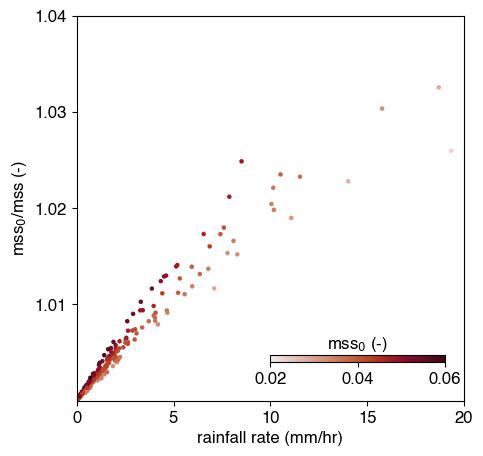

In [259]:
norm = mpl.colors.Normalize(vmin=0.02, vmax=0.06)
cmap = cmocean.cm.amp


ratio = y_corr/y
fig, ax = plt.subplots(figsize=(5, 5))
ratio_plot = ax.scatter(
    x,
    ratio,
    c=y,
    s=5,
    norm=norm,
    cmap=cmap,
)
ax.set_ylim([1, 1.04])
ax.set_yticks([1.01, 1.02, 1.03, 1.04])
ax.set_xlim([0, 20])
ax.set_ylabel('mss$_0$/mss (-)')
ax.set_xlabel('rainfall rate (mm/hr)')

cax = ax.inset_axes([0.5, 0.10, 0.45, 0.02], axes_class=mpl.axes.Axes)  # [x0, y0, width, height]
cbar = plt.colorbar(ratio_plot, cax=cax, orientation='horizontal')
cax.xaxis.set_label_position('top')
cbar.set_label('mss$_0}$ (-)')

# fig.savefig('wsra_earl_mss_transects_corrected_mss_ratio_versus_rainfall.png', dpi=400)


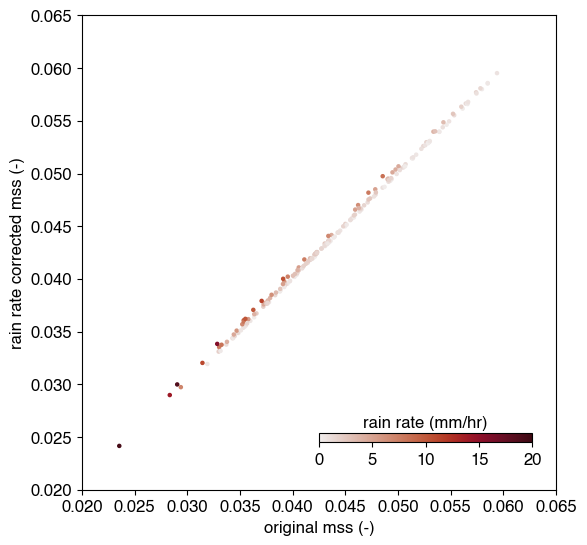

In [223]:
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = cmocean.cm.amp
fig, ax = plt.subplots(figsize=(6, 6))
comparison_plot = ax.scatter(
          y,
          y_corr,
          c=x,
          s=5,
          norm=norm,
          cmap=cmap)
ax.set_aspect('equal')
ax.set_ylabel('rain rate corrected mss (-)')
ax.set_xlabel('original mss (-)')
ax.set_xlim([0.02, 0.065])
ax.set_ylim([0.02, 0.065])

cax = ax.inset_axes([0.5, 0.10, 0.45, 0.02], axes_class=mpl.axes.Axes)  # [x0, y0, width, height]
cbar = plt.colorbar(comparison_plot, cax=cax, orientation='horizontal')
cax.xaxis.set_label_position('top')
cbar.set_label('rain rate (mm/hr)')
fig.tight_layout()
fig.savefig('wsra_earl_transects_mss_corrected_for_rainfall.png', dpi=400)

ax


### Transect alignment

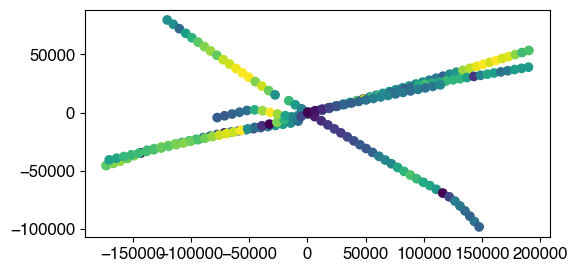

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(earl_ds_trsct_4['hurricane_eye_distance_east_storm_coord'],
           earl_ds_trsct_4['hurricane_eye_distance_north_storm_coord'],
           c=earl_ds_trsct_4['sea_surface_mean_square_slope_median'])
ax.scatter(earl_ds_trsct_3['hurricane_eye_distance_east_storm_coord'],
           earl_ds_trsct_3['hurricane_eye_distance_north_storm_coord'],
           c=earl_ds_trsct_3['sea_surface_mean_square_slope_median'])
ax.scatter(earl_ds_trsct_2['hurricane_eye_distance_east_storm_coord'],
           earl_ds_trsct_2['hurricane_eye_distance_north_storm_coord'],
           c=earl_ds_trsct_2['sea_surface_mean_square_slope_median'])
ax.scatter(earl_ds_trsct_1['hurricane_eye_distance_east_storm_coord'],
           earl_ds_trsct_1['hurricane_eye_distance_north_storm_coord'],
           c=earl_ds_trsct_1['sea_surface_mean_square_slope_median'])
ax.set_aspect('equal')

In [401]:
from scipy.ndimage import uniform_filter1d

def smooth_var(var_da, filter_size):
    interpolated = var_da.interpolate_na('time', fill_value="extrapolate")
    return uniform_filter1d(interpolated, size=filter_size)


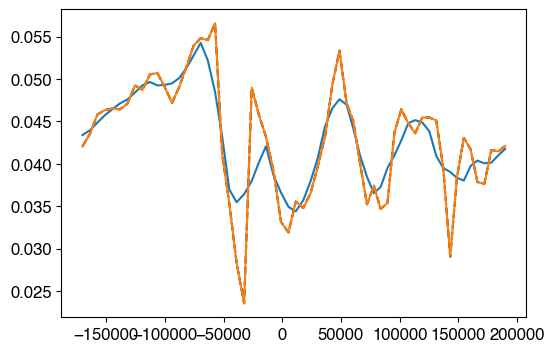

In [402]:
N=5
mss_smoothed = smooth_var(earl_ds_trsct_1['sea_surface_mean_square_slope'].mean(axis=1), N)
earl_ds_trsct_1['sea_surface_mean_square_slope_smooth'] = ('time', mss_smoothed)

rainfall_smoothed = smooth_var(earl_ds_trsct_1['rainfall_rate'].mean(axis=1), N)
earl_ds_trsct_1['rainfall_rate_smooth'] = ('time', rainfall_smoothed)

mss_smoothed = smooth_var(earl_ds_trsct_2['sea_surface_mean_square_slope'].mean(axis=1), N)
earl_ds_trsct_2['sea_surface_mean_square_slope_smooth'] = ('time', mss_smoothed)

rainfall_smoothed = smooth_var(earl_ds_trsct_2['rainfall_rate'].mean(axis=1), N)
earl_ds_trsct_2['rainfall_rate_smooth'] = ('time', rainfall_smoothed)

mss_smoothed = smooth_var(earl_ds_trsct_3['sea_surface_mean_square_slope'].mean(axis=1), N)
earl_ds_trsct_3['sea_surface_mean_square_slope_smooth'] = ('time', mss_smoothed)

rainfall_smoothed = smooth_var(earl_ds_trsct_3['rainfall_rate'].mean(axis=1), N)
earl_ds_trsct_3['rainfall_rate_smooth'] = ('time', rainfall_smoothed)

mss_smoothed = smooth_var(earl_ds_trsct_4['sea_surface_mean_square_slope'].mean(axis=1), N)
earl_ds_trsct_4['sea_surface_mean_square_slope_smooth'] = ('time', mss_smoothed)

rainfall_smoothed = smooth_var(earl_ds_trsct_4['rainfall_rate'].mean(axis=1), N)
earl_ds_trsct_4['rainfall_rate_smooth'] = ('time', rainfall_smoothed)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east_storm_coord'], earl_ds_trsct_3['sea_surface_mean_square_slope'].mean(axis=1), color='k', linestyle='--')
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east_storm_coord'], earl_ds_trsct_3['sea_surface_mean_square_slope_smooth'])
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east_storm_coord'], earl_ds_trsct_3['sea_surface_mean_square_slope'].mean(axis=1).interpolate_na('time'))

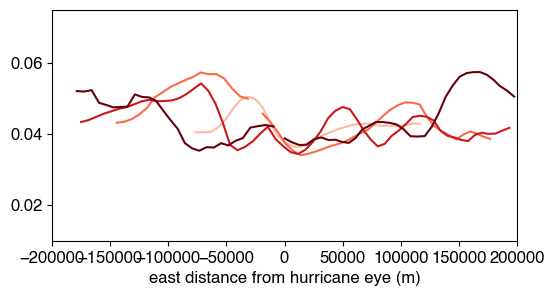

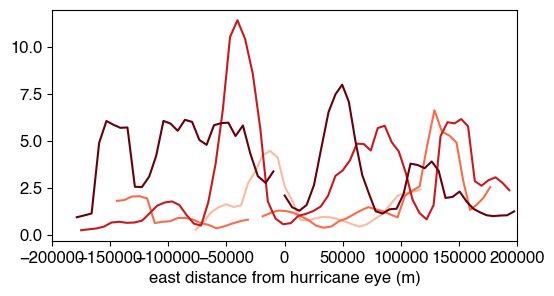

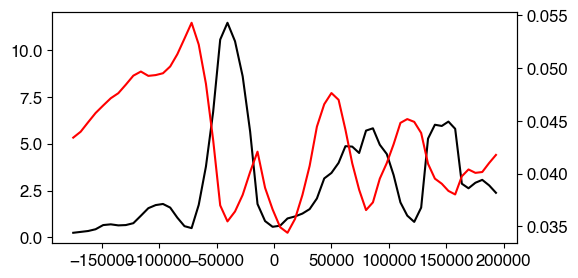

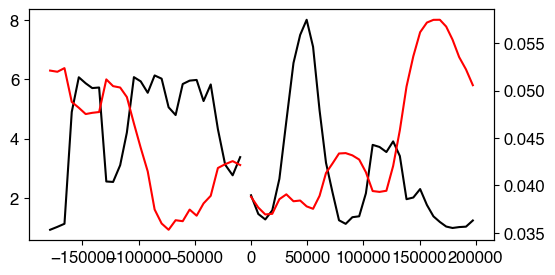

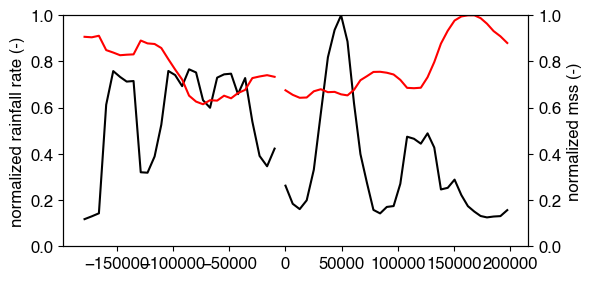

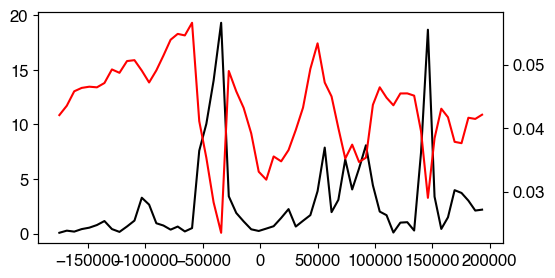

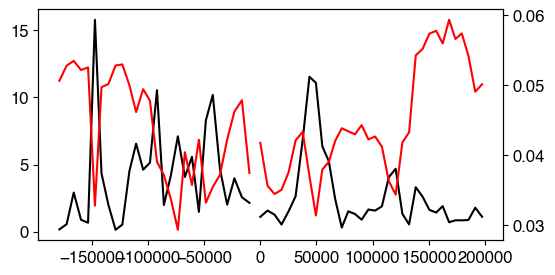

In [403]:
cmap = plt.get_cmap('Reds', 5)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_1['hurricane_eye_distance_east'], earl_ds_trsct_1['sea_surface_mean_square_slope_smooth'], color=cmap(1))
ax.plot(earl_ds_trsct_2['hurricane_eye_distance_east'], earl_ds_trsct_2['sea_surface_mean_square_slope_smooth'], color=cmap(2))
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east'], earl_ds_trsct_3['sea_surface_mean_square_slope_smooth'], color=cmap(3))
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east'], earl_ds_trsct_4['sea_surface_mean_square_slope_smooth'], color=cmap(4))
ax.set_ylim([0.01, 0.075])
ax.set_xlim(2*10**5 * np.array([-1, 1]))
ax.set_xlabel('east distance from hurricane eye (m)')


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_1['hurricane_eye_distance_east'], earl_ds_trsct_1['rainfall_rate_smooth'], color=cmap(1))
ax.plot(earl_ds_trsct_2['hurricane_eye_distance_east'], earl_ds_trsct_2['rainfall_rate_smooth'], color=cmap(2))
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east'], earl_ds_trsct_3['rainfall_rate_smooth'], color=cmap(3))
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east'], earl_ds_trsct_4['rainfall_rate_smooth'], color=cmap(4))
# ax.set_ylim([0.01, 0.075])
ax.set_xlim(2*10**5 * np.array([-1, 1]))
ax.set_xlabel('east distance from hurricane eye (m)')


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east'], earl_ds_trsct_3['rainfall_rate_smooth'], color='k')
ax2 = ax.twinx()
ax2.plot(earl_ds_trsct_3['hurricane_eye_distance_east'], earl_ds_trsct_3['sea_surface_mean_square_slope_smooth'], color='r')


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east'], earl_ds_trsct_4['rainfall_rate_smooth'], color='k')
ax2 = ax.twinx()
ax2.plot(earl_ds_trsct_4['hurricane_eye_distance_east'], earl_ds_trsct_4['sea_surface_mean_square_slope_smooth'], color='r')

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east'], earl_ds_trsct_4['rainfall_rate_smooth'] / earl_ds_trsct_4['rainfall_rate_smooth'].max(), color='k')
ax2 = ax.twinx()
ax2.plot(earl_ds_trsct_4['hurricane_eye_distance_east'], earl_ds_trsct_4['sea_surface_mean_square_slope_smooth'] / earl_ds_trsct_4['sea_surface_mean_square_slope_smooth'].max(), color='r')
ax.set_ylabel('normalized rainfall rate (-)')
ax2.set_ylabel('normalized mss (-)')
ax.set_ylim([0, 1])
ax2.set_ylim([0, 1])

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_3['hurricane_eye_distance_east'], earl_ds_trsct_3['rainfall_rate_median'], color='k')
ax2 = ax.twinx()
ax2.plot(earl_ds_trsct_3['hurricane_eye_distance_east'], earl_ds_trsct_3['sea_surface_mean_square_slope_mean_screened'], color='r')

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(earl_ds_trsct_4['hurricane_eye_distance_east'], earl_ds_trsct_4['rainfall_rate_median'], color='k')
ax2 = ax.twinx()
ax2.plot(earl_ds_trsct_4['hurricane_eye_distance_east'], earl_ds_trsct_4['sea_surface_mean_square_slope_mean_screened'], color='r')